![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [2]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Arquitectura de red del modelo - Proyecto 1


Tenemos 500000 imagenes RGB de 32x32, de 10 clases distintas (es decir 10 ouputs)
Empezamos cambiando la arquitectura.
Primero voy a añadir mayor cantidad de capas y neuronas. 4 capas de 64 neuronas y en medio un max pooling.

## la capa final del flatten antes del softmax no creo que debe ir porque solo se hace flatten antes de entrar al dense y luego el softmax actua como otra flatten de salida para el modelo

In [3]:
model = ks.Sequential()
#Extraccion de features
model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))  

model.add(ks.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.6))
#Clasificacion 

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.4))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.4))
model.add(ks.layers.Flatten())

#no cambiar esta linea de activacion
model.add(ks.layers.Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       36992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                    

## 3. Optimizador, función error


In [5]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [6]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170508288/170498071 [==============================] - 11s 0us/step


In [7]:
#y_train = y_train.ravel()



In [8]:
#y_test = y_test.ravel()



In [9]:

y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [10]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Obtenemos un array con todas las labels de CIFAR10

In [11]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [12]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train_scaled = y_train[:-10000]


In [13]:
x_val = x_train[-10000:]


In [14]:
x_train = x_train[:-10000]

In [15]:
y_train = y_train[:-10000]

In [16]:
y_val

array([[1],
       [8],
       [5],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [17]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


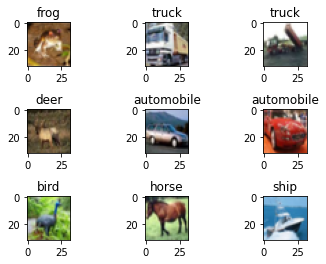

In [18]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [19]:
# Validamos el resultado
print('Train: X_scaled=%s,, xtrain = %s, y=%s' % (x_train_scaled.shape,x_train.shape, y_train_scaled.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X_scaled=(40000, 32, 32, 3),, xtrain = (40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


In [20]:
y_train

array([6, 9, 9, ..., 6, 2, 8], dtype=uint8)

In [21]:
x_train.shape

(40000, 32, 32, 3)

##Callbacks

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Prueba siendo menos estricta con patience le he subido los valores

In [23]:
# Callback con EarlyStopping basado en Accuracy
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=10)

# Callback con EarlyStopping basada en Loss
callback_loss = EarlyStopping(monitor='val_loss', patience=8)



## 4 Transformador de imagenes a datos consumibles por la red neuronal

In [24]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    horizontal_flip=False,
    vertical_flip=True,
    
    rotation_range=25,    
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.2, 
)


train_generator = train_datagen.flow(
    x_train, 
    y_train, 
    batch_size=300
)


In [25]:
validation_datagen = ImageDataGenerator(
    rescale= 1./255
    
    )

validation_generator = validation_datagen.flow(
    x_val, 
    y_val, 
    batch_size=200
)


#pintamos imagenes train

#el codigo que tenías antes no pintaba bien las imagenes aquí verás que estás haciendo con las imagenes

In [26]:
import random

In [27]:
sample = random.choice(range(0,1457))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=20
    )

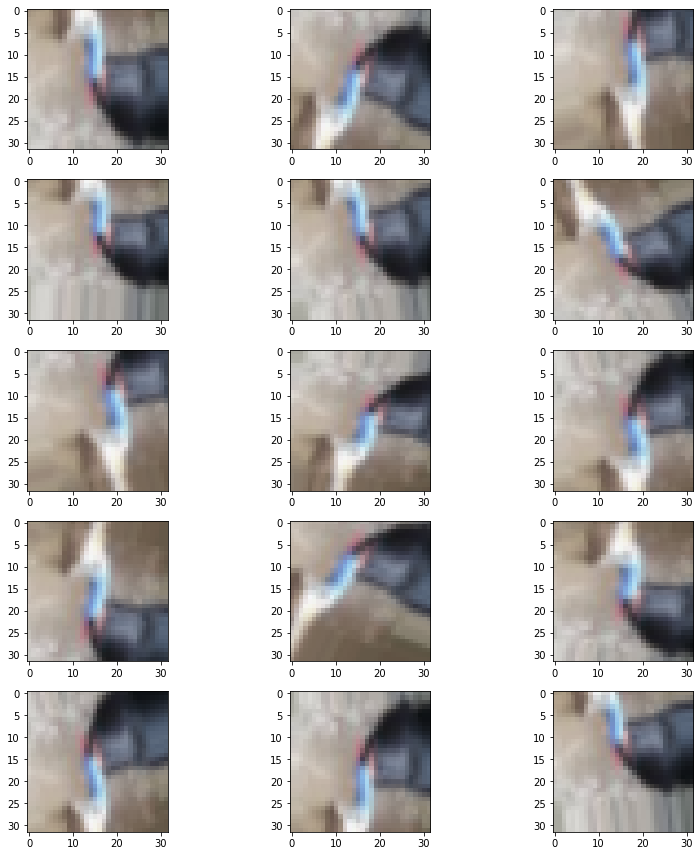

In [28]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#Pintamos Imagenes Validation

In [29]:
sample = random.choice(range(0,1457))

example_generator = validation_datagen.flow(
    x_val[sample:sample+1],
    y_val[sample:sample+1],
    batch_size=50
    )

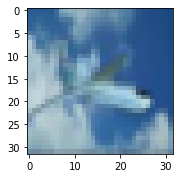

In [30]:
plt.figure(figsize=(12, 12))
for i in range(0, 1):
    plt.subplot(5, 3, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [31]:
x_train.shape

(40000, 32, 32, 3)

In [32]:
y_train.shape

(40000,)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [33]:
t = time.perf_counter()

In [34]:
#history = model.fit(x_train_scaled, y_train, epochs=30, 
#                    use_multiprocessing=True, batch_size= 512, 
 #                   validation_data=(x_val_scaled, y_val))
                    

#siempre redondea al inmediato superior en el steps per epoch

In [35]:
history = model.fit(train_generator, epochs=100, 
                   validation_data=validation_generator, 
                    steps_per_epoch=134,
                    #son los steps en funcion de la cantidad de imagenes y el batchsize del train generator(40000/300=133,33333) SE REDONDEA AL INMEDIATO SUPERIOR
                    validation_steps = 50,
                    #num de imagenes de validacion dividido por el batch del validation generator = 10000/200=50
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/100
134/134 [==============================] - 35s 161ms/step - loss: 2.1103 - accuracy: 0.1792 - val_loss: 1.9216 - val_accuracy: 0.2320
Epoch 2/100
134/134 [==============================] - 20s 147ms/step - loss: 1.8523 - accuracy: 0.2773 - val_loss: 1.6420 - val_accuracy: 0.3717
Epoch 3/100
134/134 [==============================] - 20s 146ms/step - loss: 1.7079 - accuracy: 0.3493 - val_loss: 1.5936 - val_accuracy: 0.4027
Epoch 4/100
134/134 [==============================] - 20s 145ms/step - loss: 1.6152 - accuracy: 0.3891 - val_loss: 1.6444 - val_accuracy: 0.3948
Epoch 5/100
134/134 [==============================] - 20s 148ms/step - loss: 1.5370 - accuracy: 0.4272 - val_loss: 1.4344 - val_accuracy: 0.4675
Epoch 6/100
134/134 [==============================] - 20s 147ms/step - loss: 1.4568 - accuracy: 0.4645 - val_loss: 1.3682 - val_accuracy: 0.4968
Epoch 7/100
134/134 [==============================] - 19s 144ms/step - loss: 1.3989 - accuracy: 0.4945 - val_loss: 1.2861 -

In [36]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:11:50.275563


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

#cambie el x_tested por x_test

In [37]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 72.300


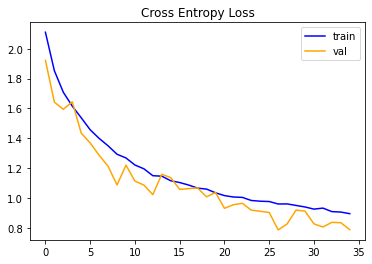

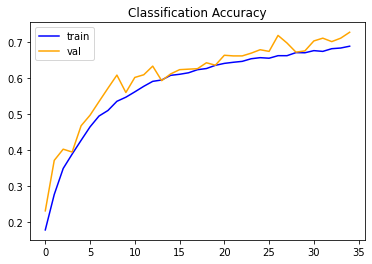

In [38]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [39]:
predictions = model.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [40]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


IndexError: ignored

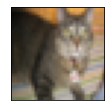

In [41]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/Deep Learning" # A revisar en vuestra instancia

model.save(/content/drive/MyDrive/Deep Learning/'cifar10_base_model6.h5')